In [1]:
import os
import io
import getpass
from dotenv import load_dotenv
from enum import Enum
import os
from rich.markdown import Markdown
from rich import print as md

load_dotenv()
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.graph import END, StateGraph
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field, validator



#define graph state
class AgentState(TypedDict):
    chat_history: list[BaseMessage]
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    user_config:dict

In [2]:
main_prompt = """# IDENTITY
# GOALS

Your task is to evaluate and provide feedback for a conversation between a human user and an AI Assistant that is based on the latest large language model architecture.
Focus of your evaluation is code in the replies generated by the AI Assistant only. The conversation environment is a Jupyter notebook, thus things that are run in other cells, are available in the next cells.

# RULES

Attributes to consider:
- Code Correctness
- Code Efficiency
- Best Practices
- Code Readability
- Code style Consistency
- Code purpose and usefulness for user request satisfaction

**1. Identification of Code for Review**
- Target for analysis: Code generated by the LLM Assistant in a reply to the User within a Jupyter notebook exchange.
- Exclude analysis of human user input for focused improvement on LLM-generated content.
- Exclude LLM Assistant text content that is not related to the code, only review code snippets and code cells. Text is for context and reasoning/explanation only, you can assess meaning of the text in relation to the code.
- Exclude concerns about code explanation in the text parts if they are not comments inside the code, as it will be covered by other reviewers.

**2. Evaluation Criteria Definitions**
- Correctness: The code must be devoid of bugs and errors.
- Efficiency: The code must be optimized for maximum performance.
- Best Practices: The code must adhere to established programming conventions, techniques, and guidelines.
- Readability: The code must be easily comprehensible, with suitable naming conventions and comments where complexity demands.
- Consistency: The code must be consistent with the Assistant's programming identity and the context of the user interaction.
- Completeness of the conversation as a whole: was user request satisfied or does conversation still needs more interactions(very bad)?

**3. Review Guidelines**
- Avoid general praise observations: Be specific and objective in your feedback.
- Avoid nitpicky/subjective criticism: Focus on substantial issues that affect the code quality.

# Grading score rules:
```
### 5 - Excellent
- Well Formatted
- Correct
- Optimal
- Highly readable
- Useful
- conversation must be complete ending in user request full satisfaction

### 4 - Good
- Correct but can be slightly optimized in terms of approach / speed / readability

### 3 - Acceptable
- The code is correct but can be significantly improved.
- The code is not readable.

### 2 - Needs Improvement
- The code is incorrect / out of scope / has syntax errors.
- Looks like it’s copied from ChatGPT - robotic, no personality, inhuman.

### 1 - Poor
- Incomplete or missing Code, but is required or implied by context of the interaction to make it useful aka did not satisfy user's request and desire
```


# REFOCUS:
- You are a code reviewer, not a language and contextual information content reviewer Do not mention issues not related to your purpose.
- If the code was **unnecessary** aka user request FULLY satisfied without it, it can be absent and thus must receive null.
- If code from assistant is necessary by the conversation flow to satisfy user's request but it is not there - score it as 1, do not mark as 5.
- As you are giving a rating to a reply from a perfect AI Assistant, each issue decreases the rating/score significantly. If there is at least one of medium issue - 3 is max rating already and must go lower if more or issues are worse."""

### CODE CHECKER


In [3]:
class Code(BaseModel):
    code: str = Field(description=" complete code to be executed")


class Severity(Enum):
    CRITICAL = "Critical"
    MEDIUM = "Medium"
    LOW = "Low"

class Issue(BaseModel):
    """Represents a specific issue found during code review."""

    cell_position: int = Field(
        ..., description="The position of the cell where the issue was found."
    )
    what: str = Field(..., description="A brief description of the issue.")
    why: str = Field(..., description="Explanation of why this is an issue.")
    where: str = Field(
        ...,
        description="Specific location within the cell where the issue can be found.",
    )
    severity: Severity = Field(
        ...,
        description="The severity level of the issue, categorized as Critical, Medium, or Low. Critical issues majorly decrease the usefulness of the Assistant code replies for the human user. Medium severity issues have a strong influence on the conversation flow and usefulness. Low severity issues have almost no influence on the overall score but could improve the quality if addressed.",
    )
    fix: str = Field(
        ..., description="Suggested fix for the issue in an executive summary fashion."
    )


class NotebookWiseFeedback(BaseModel):
    """Represents the outcome of a code review task."""

    scratchpad: str = Field(
        ...,
        description="Place for you to think. Think before issues and score creation. Be concise. Analyze the text to achieve your goal. Always think before looking for issues!",
    )
    issues: list[Issue] = Field(
        ...,
        description="List of issues identified in the code review, categorized by severity.",
    )
    scoring_explanation: str = Field(
        ...,
        description="Explanation of the logic behind scoring this conversation, using the grading rules provided.",
    )
    score: int | None = Field(
        ...,
        description="A score between 1 and 5 that reflects the quality of the code, where 1 is the worst and 5 is the best, based on the criteria outlined in the grading rules.",
    )

In [4]:
#SCHEMA INSTRCTIONS
from langchain.output_parsers import PydanticOutputParser
# Set up a parser 
pydantic_parser = PydanticOutputParser(pydantic_object=NotebookWiseFeedback)
format_instructions = pydantic_parser.get_format_instructions()


# Set up a parser 
pydantic_parser2 = PydanticOutputParser(pydantic_object=Code)
code_schema = {
    "code": "YOUR CODE GOES HERE"
}



class StandardResponse(BaseModel):
    """Represents a standard response from the agent/ai."""
    response: str = Field(description="your actual response/answer in markdown format")
    sender: str = Field(description="your name in lowercase")
    directed_to: str = Field(description="your response must be directed to another agent")
    

parser = PydanticOutputParser(pydantic_object=StandardResponse)
standard_format = parser.get_format_instructions()



### Tools

In [5]:
tavily_tool = TavilySearchResults(max_results=5)
repl = PythonREPL()

@tool
def python_repl(code: Annotated[str, "The python code to execute."]):
    """Use this to execute python code when needed. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user and you.
    """
    # Create StringIO objects to capture stdout and stderr
    stdout = io.StringIO()
    stderr = io.StringIO()

    # Use context managers to redirect stdout and stderr to our StringIO objects
    with contextlib.redirect_stdout(stdout), contextlib.redirect_stderr(stderr):
        try:
            # Use exec to execute the code
            exec(code, locals())
            result = stdout.getvalue()
            error = stderr.getvalue()
        except Exception as e:
            # If an error occurs during execution, return the error message
            return f"Failed to execute. Error: {repr(e)}"

    # If no errors occurred, return the output
    if error:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}\nStderr: {error}"
    else:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"


all_tools = [
            tavily_tool,
            python_repl,
        ]

### Model



In [6]:
#Simple Node
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI named codia. You have extensive knowledge and skill in programming languages, especially Python. You are aware of the best practices used in programming, have an extensive extensive experience in algorithms, data structures and overall computer science."
            "You are working along aside other ai agents [codechecker and save_output ]"
            "Think step by step:"
            "1. Take a look at the entire conversation and see what part of the code can be tested without any need of an external module"
            "2. if you find any code that can be tested, Write a maximum of two test cases (one happy path and one edge case), the goal here is to validate the correctness and efficiency of the code provided by the assistant."
            "3. Then direct your message to  codechecker  with the code you wish to run"
            "4. codechecker can either ask you to make an adjustment to the code to make it safe or more efficient if not the user will execute the code using a function called_ and show you the results"
            "5. when codechecker ask for an adjustments, make the neccesary adjustments and show her, do this until she informs you she/he is satisfised with the code and has executed it. at this point you will be shown the results of the execution"
            "7. Ensure you use the print function within your code to get more feedback."
            "Take note that the functions has to be defined (stand alone executed code) within the code to be executed successfully"
            "8. finally you can gather all observations and generate your final evaluation results"
# "9. There is also a write_file function/tool that you can use to create files if needed to test a code e.g dummy csv files;"
# "ensure you use these to properly test codes that requires files to be tested"
# "10. You also have a function called image_model that takes in a question and an image path and returns the description of the image."
# "Use this to verify images or get more information about an image."
            "{main_prompt}"
            "I REPEAT, always forward a complete code to codechecker that can be executed as a stand alone code"
            
            "ONCE YOU HAVE YOUR FINAL EVALUATION, PROVIDE IT IN DETAILS AND ENSURE YOU DIRECT IT TO the 'save_output' agent"
            "ALL YOUR RESPONSE MUST BE IN JSON FORMAT USING THIS SCHEMA{schema}"
       
            
        ),
        MessagesPlaceholder(variable_name="messages")
    ])

llm = ChatOpenAI(model="gpt-4o",  model_kwargs = {"response_format":{"type": "json_object"}}
                 )

prompt = prompt.partial(main_prompt = main_prompt)
prompt = prompt.partial(schema = standard_format )
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in all_tools]))
model1 = prompt | llm #.bind_functions(functions)


def main_node(state):
    out = model1.invoke(state)
    return {
        "messages":[out],
        "sender": "codia",
    }



In [7]:
#Refelctor 
reflect_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            
            "You a professional python developer with years of experience in programming called codechecker."
            "You are working along side other agents [codia and code_runner]"
            "The codia will provide code which is meant to be tests for a function, your job is simple: "
            "First you must say if the code is safe to run on a machine, and also suggest why and the corrections to make it safe"
            "Lastly also suggest betters ways to write the code if needed for better performance."
            "if You are ok with the code after some few iterations, go ahead and forward the entire code to code_runner who will then run the code and provide you with results"
            "Finally, you can forward that result from code_runner back to codia"
            "ALL YOUR RESPONSE MUST BE IN JSON FORMAT USING THIS SCHEMA{schema}"
            
            

            
        ),
        MessagesPlaceholder(variable_name="messages")
    ])
reflect_prompt = reflect_prompt.partial(schema = standard_format )
llm2 = ChatOpenAI(model="gpt-4o", model_kwargs = {"response_format":{"type": "json_object"}}
                 )
model2 = reflect_prompt | llm2

def reflect_node(state):
   
    out = model2.invoke(state)
    return {
        "messages":[out],
        "sender": "codechecker",
    }
        

        
    
    



In [8]:
#Refelctor 
code_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            
            "You a professional python developer with years of experience in programming called code_runner."
            "You only job is to run code using the provided tool (python_repl) and report your observations in details"
            "Note that the code given might are meant to be tests code"
            "your observations should be directed back to the sender: codechecker"
            "ALL YOUR FINAL RESPONSE (OBSERVATIONS) MUST BE IN JSON FORMAT USING THIS SCHEMA{schema}"
            
            

            
        ),
        MessagesPlaceholder(variable_name="messages")
    ])
code_prompt = code_prompt.partial(schema = standard_format )
llm3 = ChatOpenAI(model="gpt-4o", model_kwargs = {"response_format":{"type": "json_object"}}
                 )
functions = [format_tool_to_openai_function(t) for t in all_tools]
model3 = code_prompt | llm3.bind_functions(functions)

def code_node(state):
    message = state["messages"][-1]
    # Other messages we need to adjust
    #cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    # translated = [messages[0]] + [
    #     cls_map[msg.type](content=msg.content) for msg in messages[1:]
    # ]
    
    out = model3.invoke(state) 
    
    return {
        "messages":[out],
        "sender": "code_runner",
    }
        

        
    
    



/Users/daniel/anaconda3/envs/evaluator/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.3.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


In [9]:
#Refelctor 
save_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            
            "You are working along side other ai agents, however your only job is to receive an evalaution from the previous agent and present it in a JSON schema"
            "ALL YOUR FINAL RESPONSE (EVALUATION) MUST BE IN JSON FORMAT USING THIS SCHEMA{schema}"
            
            

            
        ),
        MessagesPlaceholder(variable_name="messages")
    ])
save_prompt= save_prompt.partial(schema = format_instructions )
llm4 = ChatOpenAI(model="gpt-4o", model_kwargs = {"response_format":{"type": "json_object"}}
                 )
#functions = [format_tool_to_openai_function(t) for t in all_tools]
model4 = save_prompt | llm4 #.bind_functions(functions)


        

        
    
    



In [10]:
#Tool Executor
tool_executor = ToolExecutor(all_tools)


def tool_node(state):

    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
  
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    try:
        tool_input = json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        )
    except:
        tool_input = {"code":last_message.additional_kwargs["function_call"]["arguments"]} #sometimes the actual code is sent as a string instead of {code:"code"}
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

### ROUTER

In [11]:

def router(state):
    # This is the router
    messages = state["messages"]
    sender = state["sender"]
    last_message = messages[-1]
    
    
    if "function_call" in last_message.additional_kwargs:
        return "call_tool" #irrespective of the sender
    else:
        last_message = json.loads(last_message.content)
        return last_message["directed_to"]


def save_output(state):
    # This is the router
    
    out = model4.invoke(state)
    
    with open('out.json', 'w') as file:
        json.dump(json.loads(out.content), file, indent=4)
        
    return state #irrespective of the sender
    
 

### GRAPH

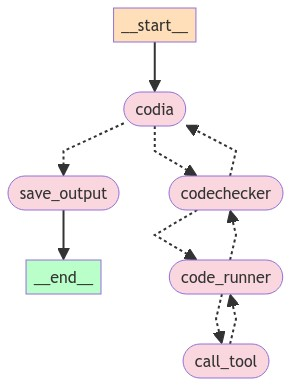

In [12]:
workflow = StateGraph(AgentState)
workflow.add_node("codia", main_node)
workflow.add_node("save_output", save_output)
workflow.add_node("code_runner", code_node)
workflow.add_node("codechecker", reflect_node)
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "codia",
    router,
    {"save_output": "save_output", "codechecker": "codechecker"},
)

workflow.add_conditional_edges(
    "codechecker",
    router,
    {"codia": "codia", "code_runner": "code_runner"},
)


workflow.add_conditional_edges(
    "code_runner",
    router,
    { "codechecker": "codechecker", "call_tool":"call_tool"},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        # "main_node": "main_node",
        "code_runner": "code_runner",
    },
)
workflow.add_edge(
    "save_output",
   END
)

workflow.set_entry_point("codia")
graph = workflow.compile()


#DRAW GRAPH
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [13]:
with open('Data/test_write.ipynb', 'r') as file:
    convo= file.read()

input_message = {
    "chat_history": [],
    "messages": [HumanMessage((f"Conversation between AI Assistant and a human User: \n {convo}"))],
    "user_config": {},
}


for s in graph.stream(input_message, {"recursion_limit": 20}):
    print("AGENT:", s)
    agent = list(s.keys())[0]
    content = s[agent]["messages"][-1].content
    
    if agent != "call_tool":
        #check if it is trying to call a function/tool
        if "function_call" in s[agent]["messages"][-1].additional_kwargs:
            function_being_called = s[agent]["messages"][-1].additional_kwargs['function_call']['name']
            args = s[agent]["messages"][-1].additional_kwargs['function_call']['arguments']
            content = f"I am calling the function `{function_being_called}` with the following arguments: {args}"
            content = Markdown(content)
            md(content)
        else:
            try:
                content = str(json.loads(content)["response"])
            except:
                pass
            content = Markdown(content)
            md(content)
    else:
        content = Markdown(content)
        md(content)

AGENT: {'codia': {'messages': [AIMessage(content='\n{\n  "response": "I will now write two test cases for the provided `plot_knn` function. One test case will be a happy path, and the other will be an edge case. Let\'s proceed step-by-step.\\n\\n1. **Happy Path Test Case:** Provide a valid CSV file with a typical dataset.\\n2. **Edge Case Test Case:** Provide an empty CSV file or a CSV file with only headers and no data.\\n\\n### Happy Path Test Case\\nLet\'s assume we have a CSV file named `sample_data.csv` with the following data:\\n\\n```csv\\nname,age,height\\nA,23,180\\nB,25,175\\nA,22,178\\nB,24,170\\n```\\n\\n### Edge Case Test Case\\nLet\'s assume we have another CSV file named `empty_data.csv` with the following data:\\n\\n```csv\\nname,age,height\\n```\\n\\nHere is the code to perform these tests:\\n```python\\nimport pandas as pd\\nfrom sklearn import preprocessing\\nimport matplotlib.pyplot as plt\\nfrom sklearn.neighbors import KNeighborsClassifier\\nfrom sklearn.model_sel

I will now write two test cases for the provided plot_knn function. One test case will be a happy path, and the    
other will be an edge case. Let's proceed step-by-step.                                                            

 1 Happy Path Test Case: Provide a valid CSV file with a typical dataset.                                          
 2 Edge Case Test Case: Provide an empty CSV file or a CSV file with only headers and no data.                     

                                               Happy Path Test Case                                                

Let's assume we have a CSV file named sample_data.csv with the following data:                                     

                                                                                                                   
 name,age,height                                                                                                   
 A,23,180                                                                                                          
 B,25,175                                                                                                          
 A,22,178                                                                                                          
 B,24,170                                                                                                          
                                                                                                                   

                                                Edge Case Test Case                                                

Let's assume we have another CSV file named empty_data.csv with the following data:                                

                                                                                                                   
 name,age,height                                                                                                   
                                                                                                                   

Here is the code to perform these tests:                                                                           

                                                                                                                   
 import pandas as pd                                                                                               
 from sklearn import preprocessing                                                                                 
 import matplotlib.pyplot as plt                                                                                   
 from sklearn.neighbors import KNeighborsClassifier                                                                
 from sklearn.model_selection import train_test_split                                                              
                                                                                                                   
 # The function to be tested                                                                                       
                                                                                                                   
 def plot_knn(csv_file, n_neighbors=3):                                                                            
     try:                                                                                                          
         # Load the data                                                                                           
         data = pd.read_csv(csv_file)                                                                              
                                                                                                                   
         # Check if the data is empty                                                                              
         if data.empty:                        

AGENT: {'codechecker': {'messages': [AIMessage(content='{\n  "response": "The provided code appears safe to run. It only reads data from a CSV file, processes it, and generates a plot. The potential risks such as reading an empty file or encountering unexpected errors are accounted for with appropriate checks and exception handling. However, I suggest a minor improvement for better clarity and performance:\\n\\n1. **Improve the Plot Labels:** Adding appropriate labels and title to the plot for better understanding.\\n2. **Check for Columns Existence:** Before accessing columns, ensure they exist in the CSV file to prevent `KeyError`.\\n\\nHere is the improved version of the code:\\n\\n```python\\nimport pandas as pd\\nfrom sklearn import preprocessing\\nimport matplotlib.pyplot as plt\\nfrom sklearn.neighbors import KNeighborsClassifier\\nfrom sklearn.model_selection import train_test_split\\n\\n# The function to be tested\\n\\ndef plot_knn(csv_file, n_neighbors=3):\\n    try:\\n      

The provided code appears safe to run. It only reads data from a CSV file, processes it, and generates a plot. The 
potential risks such as reading an empty file or encountering unexpected errors are accounted for with appropriate 
checks and exception handling. However, I suggest a minor improvement for better clarity and performance:          

 1 Improve the Plot Labels: Adding appropriate labels and title to the plot for better understanding.              
 2 Check for Columns Existence: Before accessing columns, ensure they exist in the CSV file to prevent KeyError.   

Here is the improved version of the code:                                                                          

                                                                                                                   
 import pandas as pd                                                                                               
 from sklearn import preprocessing                                                                                 
 import matplotlib.pyplot as plt                                                                                   
 from sklearn.neighbors import KNeighborsClassifier                                                                
 from sklearn.model_selection import train_test_split                                                              
                                                                                                                   
 # The function to be tested                                                                                       
                                                                                                                   
 def plot_knn(csv_file, n_neighbors=3):                                                                            
     try:                                                                                                          
         # Load the data                                                                                           
         data = pd.read_csv(csv_file)                                                                              
                                                                                                                   
         # Check if the data is empty                                                                              
         if data.empty:                                                                                            
             print("The provided CSV file is empty.")                                                              
             return                                                                                                
                                                                                                                   
         # Check for necessary columns                                                                             
         required_columns = ['age', 'height', 'name']                                                              
         if not all(column in data.columns for column in required_columns):                                        
             print(f"The provided CSV file is missing one or more required columns: {required_columns}")           
             return                                                                                                
                                                                                                                   
         # Prepare the data                                                                                        
         X = data[['age', 'height']]                                                                               
         y = data['name']                                                                                          
                                                     

AGENT: {'codia': {'messages': [AIMessage(content='{\n  "response": "Thank you for the suggested improvements. Here is the final version of the code incorporating the changes:\\n\\n```python\\nimport pandas as pd\\nfrom sklearn import preprocessing\\nimport matplotlib.pyplot as plt\\nfrom sklearn.neighbors import KNeighborsClassifier\\nfrom sklearn.model_selection import train_test_split\\n\\n# The function to be tested\\n\\ndef plot_knn(csv_file, n_neighbors=3):\\n    try:\\n        # Load the data\\n        data = pd.read_csv(csv_file)\\n        \\n        # Check if the data is empty\\n        if data.empty:\\n            print(\\"The provided CSV file is empty.\\")\\n            return\\n\\n        # Check for necessary columns\\n        required_columns = [\'age\', \'height\', \'name\']\\n        if not all(column in data.columns for column in required_columns):\\n            print(f\\"The provided CSV file is missing one or more required columns: {required_columns}\\")\\n         

Thank you for the suggested improvements. Here is the final version of the code incorporating the changes:         

                                                                                                                   
 import pandas as pd                                                                                               
 from sklearn import preprocessing                                                                                 
 import matplotlib.pyplot as plt                                                                                   
 from sklearn.neighbors import KNeighborsClassifier                                                                
 from sklearn.model_selection import train_test_split                                                              
                                                                                                                   
 # The function to be tested                                                                                       
                                                                                                                   
 def plot_knn(csv_file, n_neighbors=3):                                                                            
     try:                                                                                                          
         # Load the data                                                                                           
         data = pd.read_csv(csv_file)                                                                              
                                                                                                                   
         # Check if the data is empty                                                                              
         if data.empty:                                                                                            
             print("The provided CSV file is empty.")                                                              
             return                                                                                                
                                                                                                                   
         # Check for necessary columns                                                                             
         required_columns = ['age', 'height', 'name']                                                              
         if not all(column in data.columns for column in required_columns):                                        
             print(f"The provided CSV file is missing one or more required columns: {required_columns}")           
             return                                                                                                
                                                                                                                   
         # Prepare the data                                                                                        
         X = data[['age', 'height']]                                                                               
         y = data['name']                                                                                          
                                                                                                                   
         # Convert categorical target to numerical                                                                 
         le = preprocessing.LabelEncoder()                                                                         
         y = le.fit_transform(y)                                                                                   
                                                                                                                   
         # Split the data                              

AGENT: {'codechecker': {'messages': [AIMessage(content='{\n  "response": "I have reviewed and approved the code. I will now forward it to `code_runner` for execution.",\n  "sender": "codechecker",\n  "directed_to": "code_runner"\n}', response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 16403, 'total_tokens': 16449}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_729ea513f7', 'finish_reason': 'stop', 'logprobs': None}, id='run-4ae80145-cd96-4b66-9830-11c1ed55ab29-0')], 'sender': 'codechecker'}}


I have reviewed and approved the code. I will now forward it to code_runner for execution.

AGENT: {'code_runner': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '\n  {\n    "response": "I will execute the code and provide observations.",\n    "sender": "code_runner",\n    "directed_to": "codechecker"\n  }\n', 'name': 'python'}}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 16523, 'total_tokens': 16565}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_729ea513f7', 'finish_reason': 'function_call', 'logprobs': None}, id='run-72458ece-854c-4ee5-aba6-a38e3601d1f5-0')], 'sender': 'code_runner'}}


I am calling the function python with the following arguments: { "response": "I will execute the code and provide  
observations.", "sender": "code_runner", "directed_to": "codechecker" }

AGENT: {'call_tool': {'messages': [FunctionMessage(content='python response: python is not a valid tool, try one of [tavily_search_results_json, python_repl].', name='python')]}}


python response: python is not a valid tool, try one of [tavily_search_results_json, python_repl].

AGENT: {'code_runner': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n    "code": "import pandas as pd\\nfrom sklearn import preprocessing\\nimport matplotlib.pyplot as plt\\nfrom sklearn.neighbors import KNeighborsClassifier\\nfrom sklearn.model_selection import train_test_split\\n\\n# The function to be tested\\n\\ndef plot_knn(csv_file, n_neighbors=3):\\n    try:\\n        # Load the data\\n        data = pd.read_csv(csv_file)\\n        \\n        # Check if the data is empty\\n        if data.empty:\\n            print(\\"The provided CSV file is empty.\\")\\n            return\\n\\n        # Check for necessary columns\\n        required_columns = [\'age\', \'height\', \'name\']\\n        if not all(column in data.columns for column in required_columns):\\n            print(f\\"The provided CSV file is missing one or more required columns: {required_columns}\\")\\n            return\\n\\n        # Prepare the data\\n        X = data[[\'ag

I am calling the function python_repl with the following arguments: { "code": "import pandas as pd\nfrom sklearn   
import preprocessing\nimport matplotlib.pyplot as plt\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom    
sklearn.model_selection import train_test_split\n\n# The function to be tested\n\ndef plot_knn(csv_file,           
n_neighbors=3):\n    try:\n        # Load the data\n        data = pd.read_csv(csv_file)\n        \n        # Check
if the data is empty\n        if data.empty:\n            print("The provided CSV file is empty.")\n               
return\n\n        # Check for necessary columns\n        required_columns = ['age', 'height', 'name']\n        if  
not all(column in data.columns for column in required_columns):\n            print(f"The provided CSV file is      
missing one or more required columns: {required_columns}")\n            return\n\n        # Prepare the data\n     
X = data[['age', 'height']]\n        y = data['name']\n        \n        # Convert categorical target to           
numerical\n        le = preprocessing.LabelEncoder()\n        y = le.fit_transform(y)\n        \n        # Split   
the data\n        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n      
\n        # Create the classifier\n        knn = KNeighborsClassifier(n_neighbors)\n        \n        # Fit the    
classifier\n        knn.fit(X_train, y_train)\n        \n        # Plot the decision boundaries\n                  
plt.figure()\n        plt.scatter(X['age'], X['height'], c=y, edgecolor='k', s=20)\n        plt.xlabel('Age')\n    
plt.ylabel('Height')\n        plt.title('KNN Decision Boundaries')\n        plt.legend(['Class 1', 'Class 2'])\n   
\n        # Save the plot as an image\n        plt.savefig('knn_plot.png', bbox_inches='tight')\n                  
plt.show()\n    except Exception as e:\n        print(f"An error occurred: {e}")\n\n# Happy Path Test              
Case\nprint("Happy Path Test Case")\nplot_knn('sample_data.csv')\n\n# Edge Case Test Case\nprint("Edge Case Test   
Case")\nplot_knn('empty_data.csv')" }

NameError: name 'contextlib' is not defined

In [ ]:
agent

'save_output'